In [38]:
# Import wszystkich potrzebnych bibliotek
import numpy as np
import matplotlib.pyplot as plt
import time
from compress import *
from scipy.optimize import curve_fit
import pandas as pd

# Ustawienia wizualizacji
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

Generowanie macierzy

In [39]:
# Parametry kompresji
r = 10  # Maksymalna ranga dla kompresji
epsilon = 1e-8  # Próg dla wartości singularnych

# Generowanie macierzy dla różnych wartości k
k_values = [2, 3, 4]
matrices = {}
compressed_trees = {}

print("Generowanie macierzy siatek 3D...\n")
for k in k_values:
    print(f"k = {k}: Rozmiar 2^{3*k} = {2**(3*k)} x {2**(3*k)}")
    matrices[k] = generate_3d_mesh_matrix(k)
    print(f"  Macierz wygenerowana: {matrices[k].shape}")
    print(f"  Liczba niezerowych elementów: {np.count_nonzero(matrices[k])}")
    print(f"  Gęstość: {100 * np.count_nonzero(matrices[k]) / matrices[k].size:.2f}%\n")

Generowanie macierzy siatek 3D...

k = 2: Rozmiar 2^6 = 64 x 64
  Macierz wygenerowana: (64, 64)
  Liczba niezerowych elementów: 288
  Gęstość: 7.03%

k = 3: Rozmiar 2^9 = 512 x 512
  Macierz wygenerowana: (512, 512)
  Liczba niezerowych elementów: 2688
  Gęstość: 1.03%

k = 4: Rozmiar 2^12 = 4096 x 4096
  Macierz wygenerowana: (4096, 4096)
  Liczba niezerowych elementów: 23040
  Gęstość: 0.14%



In [40]:
# Kompresja macierzy
compression_stats = {}

for k in k_values:
    print(f"\nKompresja dla k = {k}...")
    compressed_trees[k] = CompressMatrix(matrices[k], r, epsilon)


Kompresja dla k = 2...

Kompresja dla k = 3...

Kompresja dla k = 4...


## 3. Wizualizacja Struktury Skompresowanych Macierzy

Poniżej przedstawiamy wizualizację podziału hierarchicznego dla każdej macierzy:

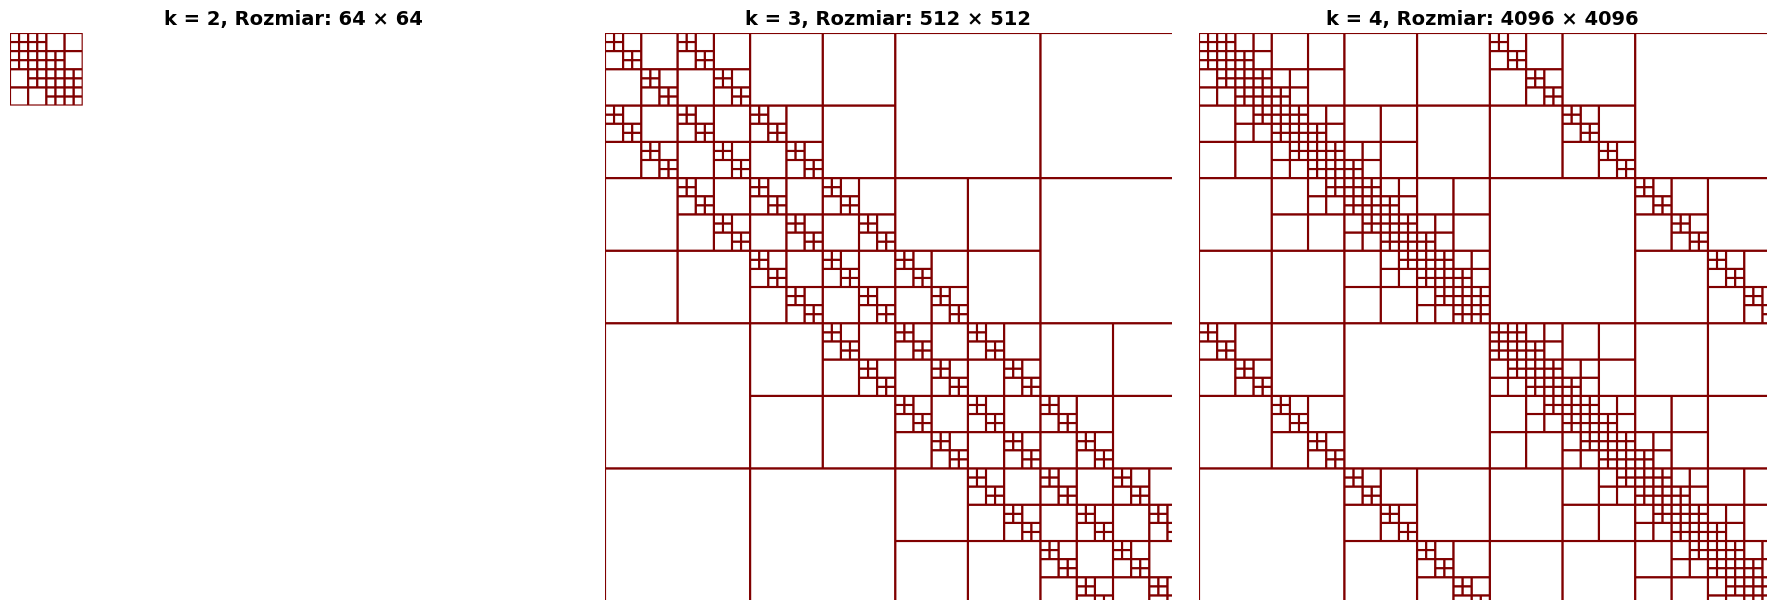

Wizualizacje zapisane jako 'compressed_matrix_structure.png'


In [41]:
# Wizualizacja struktury macierzy
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, k in enumerate(k_values):
    img = draw_vis(compressed_trees[k])
    axes[idx].imshow(img)
    axes[idx].set_title(f'k = {k}, Rozmiar: {2**(3*k)} × {2**(3*k)}', 
                        fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Wizualizacje zapisane jako 'compressed_matrix_structure.png'")

Mnożenie macierzy przez wektor

In [42]:
# Test mnożenia przez wektor
print("\n" + "="*70)
print("ZADANIE 1: MNOŻENIE SKOMPRESOWANEJ MACIERZY PRZEZ WEKTOR")
print("="*70 + "\n")

vector_mult_times = {}
vector_mult_errors = {}
num_trials = 5  # Liczba prób dla uśrednienia

for k in k_values:
    n = 2**(3*k)
    print(f"\nk = {k}, N = {n}:")
    
    # Generuj losowy wektor
    x = np.random.randn(n)
    
    # Mnożenie oryginalne (referencyjne)
    y_original = matrices[k] @ x
    
    # Mnożenie skompresowane - wielokrotne próby
    times = []
    for trial in range(num_trials):
        start = time.time()
        y_compressed = matrix_vector_mult(compressed_trees[k], x)
        elapsed = time.time() - start
        times.append(elapsed)
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    vector_mult_times[k] = avg_time
    
    # Oblicz błąd
    error = np.linalg.norm(y_original - y_compressed)
    relative_error = error / np.linalg.norm(y_original)
    vector_mult_errors[k] = error
    
    print(f"  Średni czas: {avg_time*1000:.4f} ms (±{std_time*1000:.4f} ms)")
    print(f"  Błąd ||Ax - Hx||₂: {error:.6e}")
    print(f"  Błąd względny: {relative_error:.6e}")


ZADANIE 1: MNOŻENIE SKOMPRESOWANEJ MACIERZY PRZEZ WEKTOR


k = 2, N = 64:
  Średni czas: 0.1028 ms (±0.0545 ms)
  Błąd ||Ax - Hx||₂: 6.811902e-15
  Błąd względny: 6.429634e-16

k = 3, N = 512:
  Średni czas: 1.2994 ms (±0.4190 ms)
  Błąd ||Ax - Hx||₂: 2.755429e-14
  Błąd względny: 9.194060e-16

k = 4, N = 4096:
  Średni czas: 23.8185 ms (±2.8092 ms)
  Błąd ||Ax - Hx||₂: 6.008540e-14
  Błąd względny: 6.884511e-16


## 5. Analiza Złożoności Obliczeniowej - Mnożenie przez Wektor

Dopasowujemy funkcję $T(N) = \alpha N^\beta$ do zmierzonych czasów.

In [43]:
# Dopasowanie krzywej α*N^β
sizes = np.array([2**(3*k) for k in k_values])
times = np.array([vector_mult_times[k] for k in k_values])

def power_law(N, alpha, beta):
    return alpha * N**beta

# Dopasowanie
popt, pcov = curve_fit(power_law, sizes, times, p0=[1e-6, 1.0])
alpha, beta = popt

print(f"\nDopasowana funkcja: T(N) = {alpha:.6e} * N^{beta:.4f}")
print(f"\nZłożoność eksperymentalna: O(N^{beta:.2f})")

# Porównanie z teoretyczną złożonością O(N log N)
print(f"Teoretyczna złożoność dla H-macierzy: O(N log N)")
print(f"Współczynnik β = {beta:.2f} vs teoretyczny ≈ 1.0-1.2")


Dopasowana funkcja: T(N) = 2.132450e-07 * N^1.3974

Złożoność eksperymentalna: O(N^1.40)
Teoretyczna złożoność dla H-macierzy: O(N log N)
Współczynnik β = 1.40 vs teoretyczny ≈ 1.0-1.2


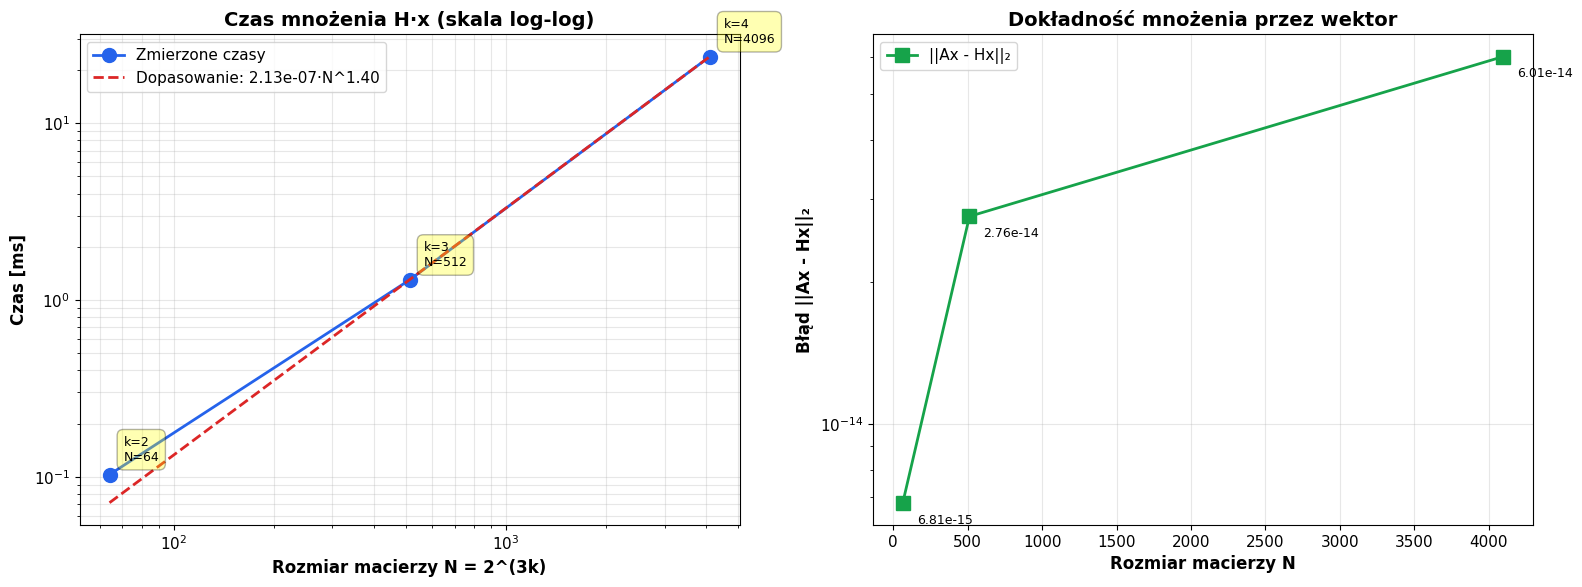

In [44]:
# Wykres czasu mnożenia przez wektor
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Czas vs rozmiar (skala log-log)
N_plot = np.linspace(sizes[0], sizes[-1], 100)
T_fit = power_law(N_plot, alpha, beta)

ax1.loglog(sizes, times * 1000, 'o-', markersize=10, linewidth=2, 
           label='Zmierzone czasy', color='#2563eb')
ax1.loglog(N_plot, T_fit * 1000, '--', linewidth=2, 
           label=f'Dopasowanie: {alpha:.2e}·N^{beta:.2f}', color='#dc2626')
ax1.set_xlabel('Rozmiar macierzy N = 2^(3k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Czas [ms]', fontsize=12, fontweight='bold')
ax1.set_title('Czas mnożenia H·x (skala log-log)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend(fontsize=11)

# Dodaj etykiety punktów
for k, size, t in zip(k_values, sizes, times):
    ax1.annotate(f'k={k}\nN={size}', xy=(size, t*1000), xytext=(10, 10),
                textcoords='offset points', fontsize=9, 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

# Wykres 2: Błąd rekonstrukcji
errors = [vector_mult_errors[k] for k in k_values]
ax2.semilogy(sizes, errors, 's-', markersize=10, linewidth=2, 
             label='||Ax - Hx||₂', color='#16a34a')
ax2.set_xlabel('Rozmiar macierzy N', fontsize=12, fontweight='bold')
ax2.set_ylabel('Błąd ||Ax - Hx||₂', fontsize=12, fontweight='bold')
ax2.set_title('Dokładność mnożenia przez wektor', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

for k, size, err in zip(k_values, sizes, errors):
    ax2.annotate(f'{err:.2e}', xy=(size, err), xytext=(10, -15),
                textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

mnożenie macierzy skompresowanej przez samą siebie

In [45]:
# Test mnożenia macierzy przez siebie
print("\n" + "="*70)
print("ZADANIE 2: MNOŻENIE SKOMPRESOWANEJ MACIERZY PRZEZ SIEBIE (H * H)")
print("="*70 + "\n")

matrix_mult_times = {}
matrix_mult_errors = {}
target_rank_mult = 15  # Zwiększona ranga dla iloczynu

for k in k_values:
    n = 2**(3*k)
    print(f"\nk = {k}, N = {n}:")
    
    # Mnożenie skompresowane H * H
    start = time.time()
    result_tree = matrix_matrix_mult(compressed_trees[k], compressed_trees[k], target_rank_mult)
    mult_time = time.time() - start
    matrix_mult_times[k] = mult_time
    
    print(f"  Czas mnożenia H*H: {mult_time:.4f} s")
    
    # Rekonstrukcja i porównanie z oryginalnym A*A
    print(f"  Rekonstrukcja macierzy...")
    H_squared = ReconstructMatrix(result_tree, matrices[k].shape)
    
    # Obliczenie A*A dla małych macierzy (k <= 3)
    if k <= 3:
        print(f"  Obliczanie A*A (referencja)...")
        A_squared = matrices[k] @ matrices[k]
        
        # Błąd Frobeniusa
        error_frobenius = np.linalg.norm(A_squared - H_squared, 'fro')
        relative_error = error_frobenius / np.linalg.norm(A_squared, 'fro')
        matrix_mult_errors[k] = error_frobenius
        
        print(f"  Błąd ||A² - H²||_F: {error_frobenius:.6e}")
        print(f"  Błąd względny: {relative_error:.6e}")
    else:
        print(f"  (Pomijam obliczanie A*A dla k={k} - zbyt duża macierz)")
        matrix_mult_errors[k] = None
    
    # Statystyki skompresowanej macierzy wynikowej
    result_stats = calculate_compression_stats(result_tree, matrices[k].shape)
    print(f"  Parametry H²: {result_stats['compressed_elements']:,}")
    print(f"  Współczynnik kompresji H²: {result_stats['compression_ratio']:.2f}x")


ZADANIE 2: MNOŻENIE SKOMPRESOWANEJ MACIERZY PRZEZ SIEBIE (H * H)


k = 2, N = 64:
  Czas mnożenia H*H: 0.0131 s
  Rekonstrukcja macierzy...
  Obliczanie A*A (referencja)...
  Błąd ||A² - H²||_F: 1.812623e+01
  Błąd względny: 1.012267e+00
  Parametry H²: 3,944
  Współczynnik kompresji H²: 1.04x

k = 3, N = 512:
  Czas mnożenia H*H: 0.0614 s
  Rekonstrukcja macierzy...
  Obliczanie A*A (referencja)...
  Błąd ||A² - H²||_F: 6.603489e+01
  Błąd względny: 1.049296e+00
  Parametry H²: 62,980
  Współczynnik kompresji H²: 4.16x

k = 4, N = 4096:
  Czas mnożenia H*H: 1.2629 s
  Rekonstrukcja macierzy...
  (Pomijam obliczanie A*A dla k=4 - zbyt duża macierz)
  Parametry H²: 385,662
  Współczynnik kompresji H²: 43.50x


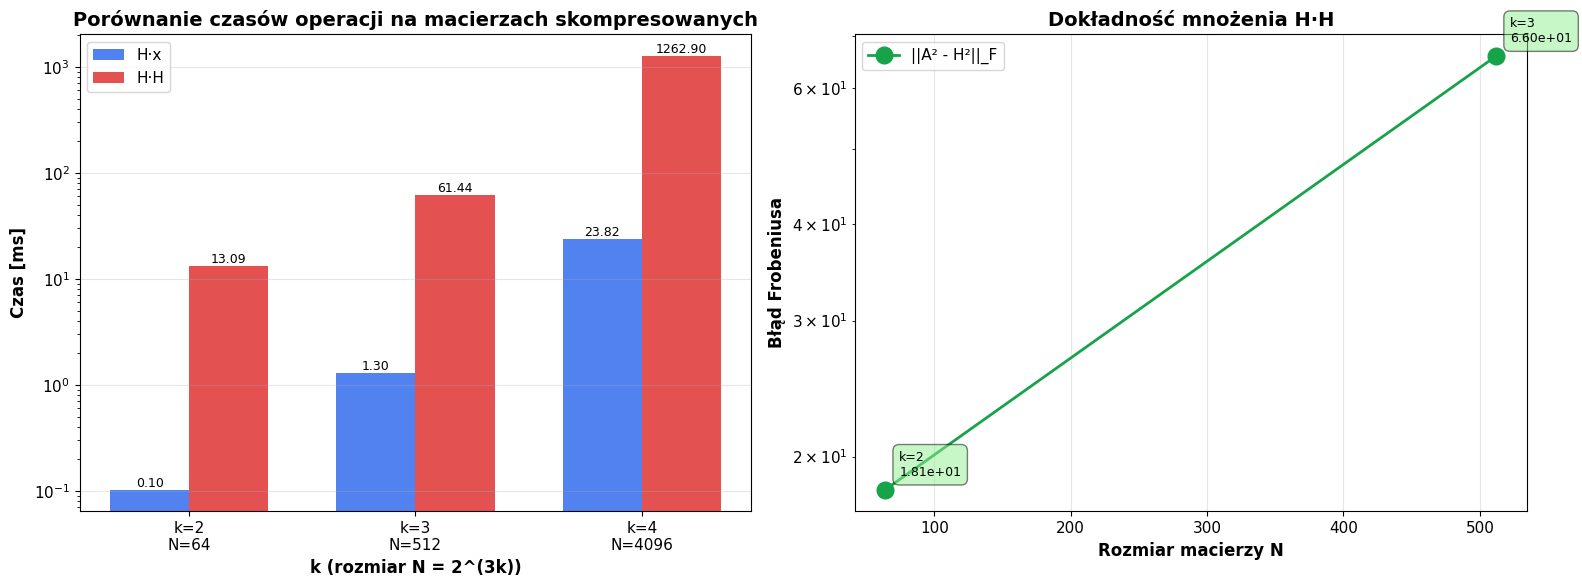

In [46]:
# Wykres porównawczy czasów
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Porównanie czasów operacji
x_pos = np.arange(len(k_values))
width = 0.35

vec_times = [vector_mult_times[k] * 1000 for k in k_values]
mat_times = [matrix_mult_times[k] * 1000 for k in k_values]

bars1 = ax1.bar(x_pos - width/2, vec_times, width, label='H·x', color='#2563eb', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, mat_times, width, label='H·H', color='#dc2626', alpha=0.8)

ax1.set_xlabel('k (rozmiar N = 2^(3k))', fontsize=12, fontweight='bold')
ax1.set_ylabel('Czas [ms]', fontsize=12, fontweight='bold')
ax1.set_title('Porównanie czasów operacji na macierzach skompresowanych', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'k={k}\nN={2**(3*k)}' for k in k_values])
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_yscale('log')

# Dodaj wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

# Wykres 2: Błędy dla dostępnych k
available_k = [k for k in k_values if matrix_mult_errors[k] is not None]
available_errors = [matrix_mult_errors[k] for k in available_k]

if available_errors:
    ax2.semilogy([2**(3*k) for k in available_k], available_errors, 'o-', 
                 markersize=12, linewidth=2, color='#16a34a', label='||A² - H²||_F')
    ax2.set_xlabel('Rozmiar macierzy N', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Błąd Frobeniusa', fontsize=12, fontweight='bold')
    ax2.set_title('Dokładność mnożenia H·H', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    
    for k, err in zip(available_k, available_errors):
        ax2.annotate(f'k={k}\n{err:.2e}', xy=(2**(3*k), err), xytext=(10, 10),
                    textcoords='offset points', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()